# Grover's algorithm using the Sampler primitive

## Background

Amplitude amplification is a general purpose quantum algorithm, or subroutine, that can be used to obtain a quadratic speedup over a handful of classical algorithms. [Grover’s algorithm](https://arxiv.org/abs/quant-ph/9605043) was the first to demonstrate this speed up on unstructured search problems.  Formulating a Grover's search problem requires an oracle function that marks one or more computational basis states as the states we are interested in finding, and an amplification circuit that increases the amplitude of marked states, consequently suppressing the remaining states. 

Here we demonstrate how to construct Grover oracles and make use of the `GroverOperator` from the Qiskit circuit library, to easily setup a Grover's search instance.  The runtime `Sampler` allows for seamless execution of Grover circuits, including automatic compilation, error suppression, and readout error mitigation techniques.

## Setup

Here we import the small number tools we need for this tutorial.

In [24]:
# Built-in modules
import math

# Imports from Qiskit
from qiskit import QuantumCircuit
from qiskit.circuit.library import GroverOperator, MCMT, ZGate
from qiskit.visualization import plot_distribution

# Imports from Qiskit Runtime
from qiskit_ibm_runtime import QiskitRuntimeService, Sampler

## Initialize Runtime service and select backends

Here we instantiate the Runtime service that gives access to the quantum devices and simulator that we use in this tutorial.  Here we make use of a simulator to validate our circuit, and then turn to execution on a real quantum system.

In [3]:
service = QiskitRuntimeService()

In [32]:
sim = service.get_backend("ibmq_qasm_simulator")
backend = service.get_backend("ibm_brisbane")

## Define a Grover experiment

Grover's algorithm requires an [oracle](https://quantum-computing.ibm.com/admin/docs/admin/guide/grovers-algorithm#the-oracle) that specifies one or more marked computational basis states, where "marked" means a state with a phase of -1.  A controlled-Z gate, or its multi-controlled generalization over $N$ qubits, marks the $2^{N}-1$ state (`'1'`*$N$ bit-string).  Marking basis states with one or more `'0'` in the binary representation requires applying X-gates on the corresponding qubits before and after the controlled-Z gate; equivalent to having an open-control on that qubit.  In the following, we define an oracle that does just that, marking one or more input basis states defined through their bit-string representation.  The `MCMT` gate is used to implement the multi-controlled Z-gate.

In [5]:
def grover_oracle(marked_states):
    """Build a Grover oracle for multiple marked states

    Here we assume all input marked states have the same number of bits

    Parameters:
        marked_states (str or list): Marked states of oracle

    Returns:
        QuantumCircuit: Quantum circuit representing Grover oracle
    """
    if not isinstance(marked_states, list):
        marked_states = [marked_states]
    # Compute the number of qubits in circuit
    num_qubits = len(marked_states[0])

    qc = QuantumCircuit(num_qubits)
    # Mark each target state in the input list
    for target in marked_states:
        # Flip target bit-string to match Qiskit bit-ordering
        rev_target = target[::-1]
        # Find the indices of all the '0' elements in bit-string
        zero_inds = [
            ind for ind in range(num_qubits) if rev_target.startswith("0", ind)
        ]
        # Add a multi-controlled Z-gate with pre- and post-applied X-gates (open-controls)
        # where the target bit-string has a '0' entry
        qc.x(zero_inds)
        qc.compose(MCMT(ZGate(), num_qubits - 1, 1), inplace=True)
        qc.x(zero_inds)
    return qc

### Specific Grover's instance

With the oracle function in hand, we can now define a specific instance of Grover search.  In this example we will mark two computational states out of the 8 available in a 3-qubit computational space:

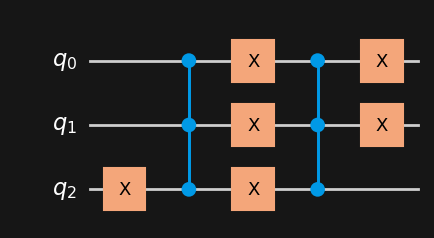

In [6]:
marked_states = ["011", "100"]

oracle = grover_oracle(marked_states)
oracle.draw("mpl")

### The `GroverOperator`

The built-in Qiskit `GroverOperator` takes an oracle circuit, and returns a circuit that is composed of the oracle circuit circuit itself, and a circuit that amplifies the states marked by the oracle.  Here we `decompose` the circuit to see the gates within the operator:

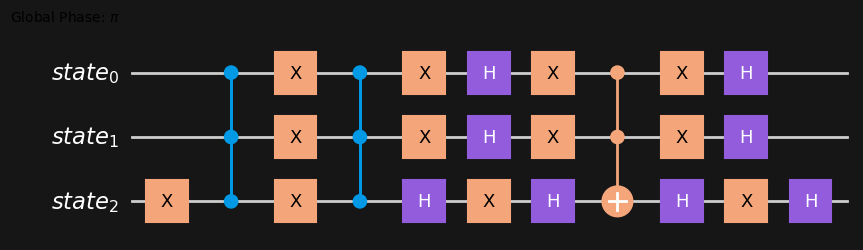

In [7]:
grover_op = GroverOperator(oracle)
grover_op.decompose().draw("mpl")

Repeated applications of this `grover_op` circuit amplify the marked states, making them the most probable bit-strings in the output distribution from the circuit.  There is an optimal number of such applications that is determined by the ratio of marked states to total number of possible computational states:

In [8]:
optimal_num_iterations = math.floor(
    math.pi / 4 * math.sqrt(2**grover_op.num_qubits / len(marked_states))
)

### Full Grover circuit

A complete Grover experiment starts with a Hadamard gate on each qubit; creating an even superposition of all computational basis states, followed the Grover operator (`grover_op`) repeated the optimal number of times.  Here we make use of the `QuantumCircuit.power(INT)` method to repeatedly apply the Grover operator.

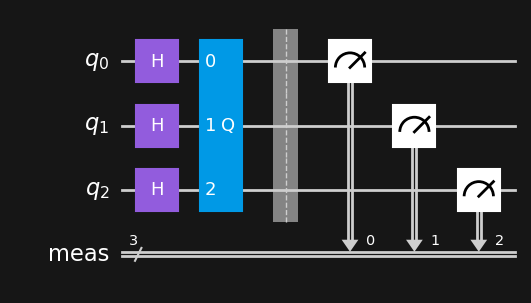

In [9]:
qc = QuantumCircuit(grover_op.num_qubits)
# Create even superposition of all basis states
qc.h(range(grover_op.num_qubits))
# Apply Grover operator the optimal number of times
qc.compose(grover_op.power(optimal_num_iterations), inplace=True)
# Measure all qubits
qc.measure_all()
qc.draw("mpl")

## Execution with the Sampler primitive

Amplitude amplification is a sampling problem that is suitable for execution with the `Sampler` runtime primitive. Because we have a single-circuit, we instantiate a `Sampler` using the target backend.  To begin, this is the simulator:

In [33]:
sim_sampler = Sampler(session=sim)

and execute the circuit using `sampler.run`.  The result is obtained in the returned quasi-probability distribution:

In [34]:
sim_dist = sim_sampler.run(qc, shots=int(1e4)).result().quasi_dists[0]

To see that the marked states are visible in the returned distribution, we convert the returned quasi-probability distribution from integer to bit-string representation to compare to the list of `marked_states`.

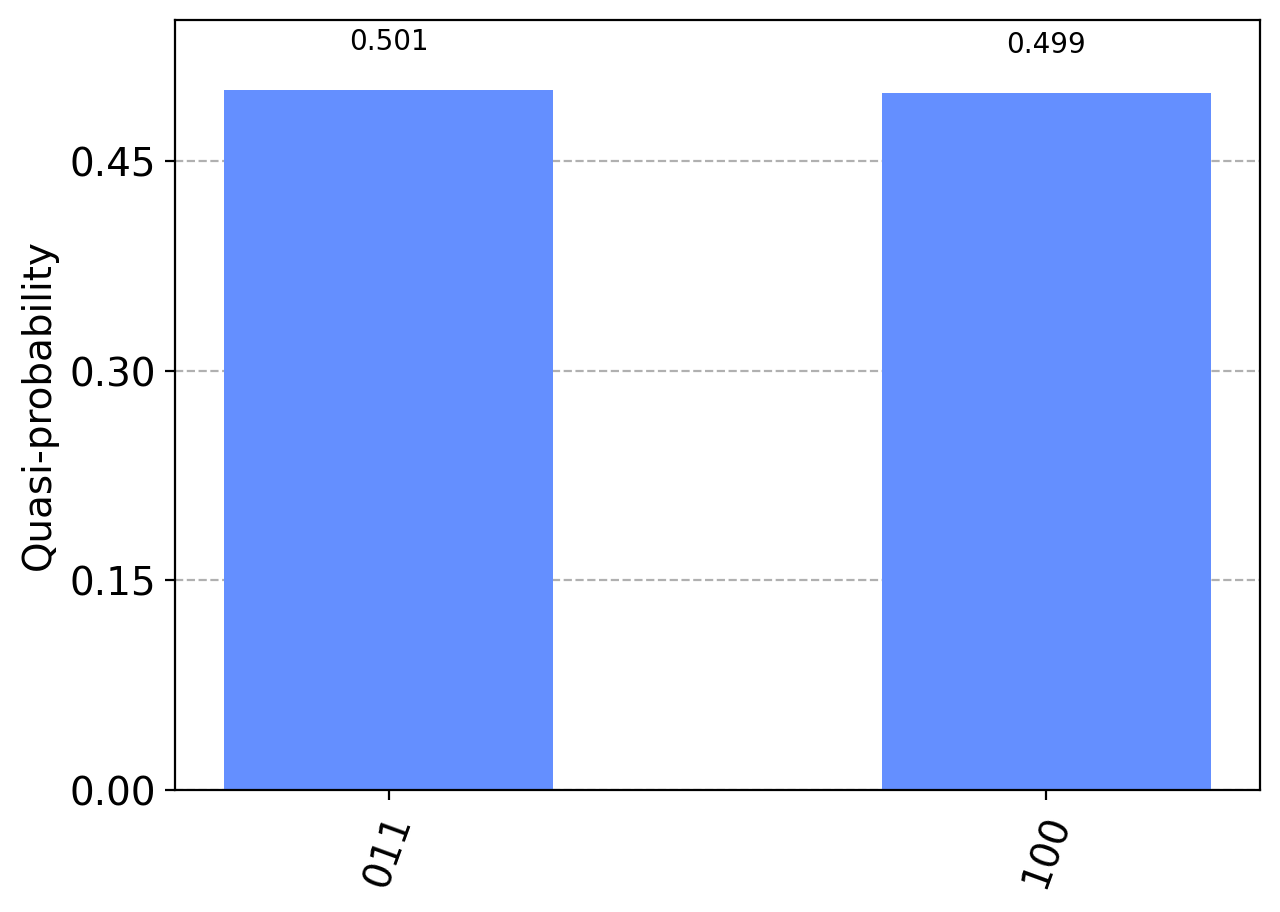

In [35]:
plot_distribution(sim_dist.binary_probabilities())

Having verified that our code does indeed produce the desired outcome, we now execute it on a real device, creating an `Estimator` instance targeting that system:

In [36]:
real_sampler = Sampler(session=backend)

In [37]:
real_dist = real_sampler.run(qc, shots=int(1e4)).result().quasi_dists[0]

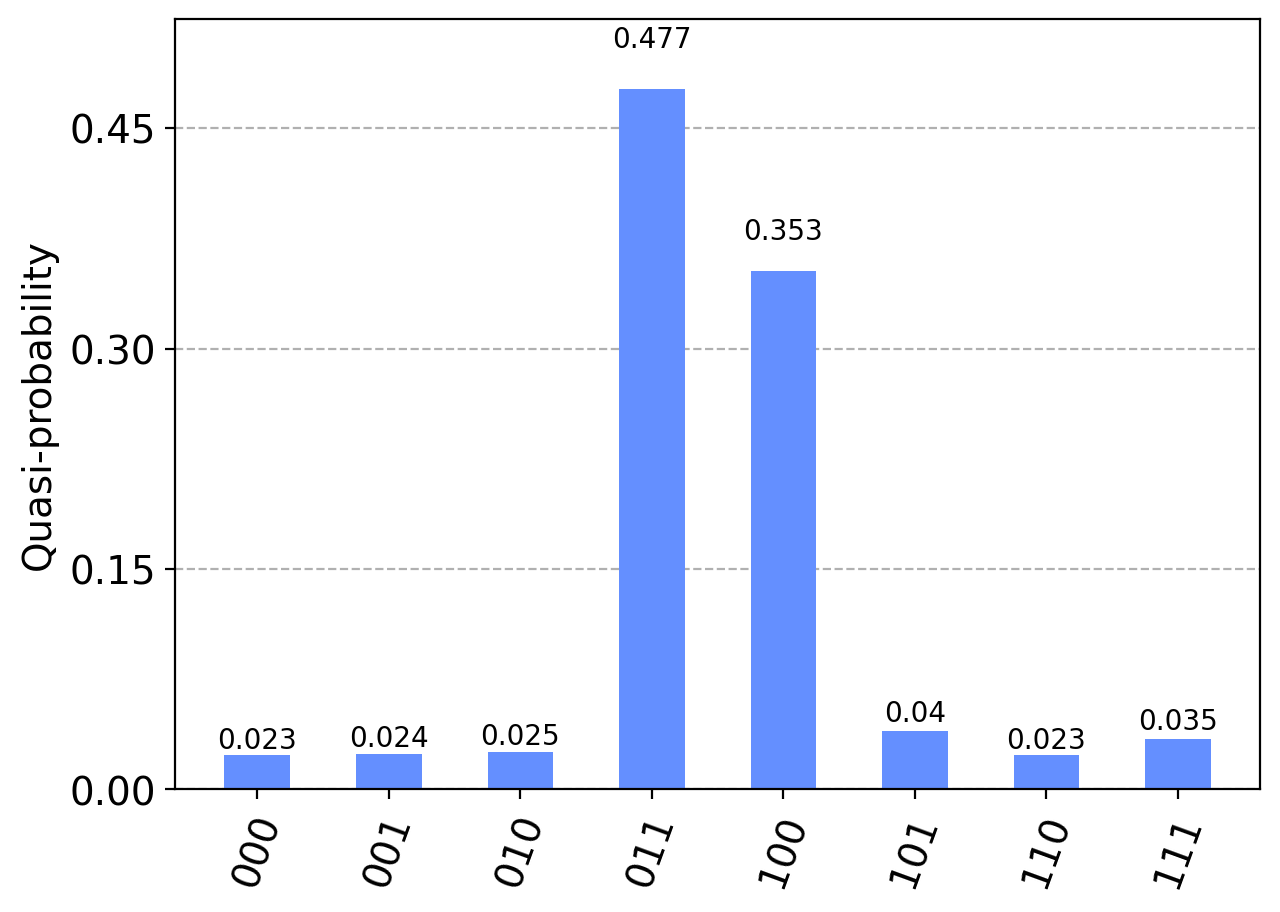

In [38]:
plot_distribution(real_dist.binary_probabilities())